In [1]:
#read in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd()

'/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts'

# format gwas table for SNPEff

In [ ]:
#NICSA
dir="/tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_gwas/results/gwas/mlma_concat/"
Files=['regressedlr_smkinit_pc1', 'regressedlr_cigday_pc1']

In [8]:
#LOCO-meta-analysis
dir="/tscc/projects/ps-palmer/brittany/SUD_cross_species/"
Files=['regressedlr_combined_locomotor']

In [9]:
def modify_tbl(File):
    tbl=pd.read_csv(dir+File+'.mlma', sep="\t")
    
    sumstat=tbl
    col_aln={'Chr':'CHROM', 'SNP':'ID','bp':'POS','A1':'ALT','A2':'REF','b':'ES', 'se':'SE','p':'PVAL'}
    sumstat=sumstat.rename(columns=col_aln)
    sumstat['QUAL']='.'
    sumstat['FILTER']='.'
    sumstat['INFO']='.'
    sumstat['LP']=-1*np.log10(sumstat['PVAL'])
    colorder=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO', 'ES', 'SE', 'PVAL','LP']
    vcf=sumstat[colorder]

    vcf.to_csv(dir+File+"_sumstat.VCF",sep="\t",index=False)
    tbl.to_csv(dir+File+"_sumstat.mlma",sep="\t",index=False)
    vcf[vcf['PVAL']<.05].to_csv(File+"_subset_sumstat.VCF",sep="\t",index=False)
    return(vcf)

In [10]:
tbls = [modify_tbl(File) for File in Files]

# run snpeff

In [ ]:
#smkinit
/tscc/projects/ps-palmer/brittany/jdk-20/bin/java -Xms40g -Xmx40g -jar /tscc/projects/ps-palmer/brittany/snpEff/snpEff.jar mRatBN7.2.105 /tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_gwas/results/gwas/mlma_concat/regressedlr_smkinit_pc1_sumstat.VCF > /tscc/projects/ps-palmer/brittany/SUD_cross_species/regressedlr_smkinit_pc1.ann.vcf


In [ ]:
#cigday
/tscc/projects/ps-palmer/brittany/jdk-20/bin/java -Xms40g -Xmx40g -jar /tscc/projects/ps-palmer/brittany/snpEff/snpEff.jar mRatBN7.2.105 /tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_gwas/results/gwas/mlma_concat/regressedlr_cigday_pc1_sumstat.VCF > /tscc/projects/ps-palmer/brittany/SUD_cross_species/regressedlr_cigday_pc1.ann.vcf


In [ ]:
#loco
/tscc/projects/ps-palmer/brittany/jdk-20/bin/java -Xms40g -Xmx40g -jar /tscc/projects/ps-palmer/brittany/snpEff/snpEff.jar mRatBN7.2.105 /tscc/projects/ps-palmer/brittany/SUD_cross_species/regressedlr_combined_locomotor.VCF > /tscc/projects/ps-palmer/brittany/SUD_cross_species/regressedlr_combined_locomotor.ann.vcf


In [18]:
ls /tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_gwas/results/gwas/mlma_concat/

regressedlr_cigday_pc1.mlma          regressedlr_smkinit_pc1.mlma
regressedlr_cigday_pc1_sumstat.mlma  regressedlr_smkinit_pc1_sumstat.mlma
regressedlr_cigday_pc1_sumstat.VCF   regressedlr_smkinit_pc1_sumstat.VCF


# format snpeff output for readability

In [4]:
snpeff_path='/tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_snpeff/'

In [19]:
Files=[snpeff_path+'regressedlr_cigday_pc1.ann.vcf', 
       snpeff_path+'regressedlr_smkinit_pc1.ann.vcf',
      ]


In [22]:
c=pd.read_csv(Files[0], sep="\t", skiprows=5,low_memory=False)

In [26]:
cig=format_out(c)

In [27]:
s=pd.read_csv(Files[1], sep="\t", skiprows=5,low_memory=False)
smk=format_out(s)

In [25]:
def format_out(tbl):
    #filter tbl to remove NA associations
    tbl=tbl[tbl['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND']!='.']
    #split tbl INFO annotation column by individual annotation (,)
    tbl['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND']=tbl['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND'].map(lambda s:list(s.split(',')))
    #tbl['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND'][tbl['PVAL']<1e-4].map(lambda s:len(s))
    #get N annotations
    tbl['N_ann']=tbl['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND'].map(lambda s:len(s))
    #make single row per annotation column, merge back into t_exp
    t_exp=tbl.explode('INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND')
    t_exp['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND']=t_exp['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND'].map(lambda s:list(s.split('|')))
    split = pd.DataFrame(t_exp['INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND'].to_list()).iloc[:,[0,1,2,3,4,5]]
    split = split.replace(r'^\s*$', np.nan, regex=True)
    split = split.reset_index(drop=True)
    split.columns= ['Allele', 'Annotation', 'Impact','Gene','Gene_ID', 'Feature_Type']
    t_exp= t_exp.reset_index(drop=True)
    t_exp = pd.concat([t_exp, split], axis=1)
    return(t_exp)
    

In [31]:
cig=cig['Annotation']

,CHROM,0,ID,REF,ALT,0.0,FILTER,INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND,ES,SE,PVAL,LP,N_ann,Allele,Annotation,Impact,Gene,Gene_ID,Feature_Type
0,1,735254,1:735254,G,A,.,.,"[ANN=A, intron_variant, MODIFIER, Vom2r1, ENSR...",0.099011,0.060797,0.103408,0.985446,1,ANN=A,intron_variant,MODIFIER,Vom2r1,ENSRNOG00000067992,transcript
1,1,763121,1:763121,T,C,.,.,"[ANN=C, intron_variant, MODIFIER, Vom2r1, ENSR...",0.112691,0.062290,0.070430,1.152243,1,ANN=C,intron_variant,MODIFIER,Vom2r1,ENSRNOG00000067992,transcript
2,1,767113,1:767113,G,A,.,.,"[ANN=A, intron_variant, MODIFIER, Vom2r1, ENSR...",0.110480,0.062191,0.075657,1.121149,1,ANN=A,intron_variant,MODIFIER,Vom2r1,ENSRNOG00000067992,transcript
3,1,1113500,1:1113500,A,T,.,.,"[ANN=T, intergenic_region, MODIFIER, AABR07002...",0.094927,0.075245,0.207102,0.683816,1,ANN=T,intergenic_region,MODIFIER,AABR07002209.1-Vom2r6,ENSRNOG00000062307-ENSRNOG00000069767,intergenic_region
4,1,1124362,1:1124362,A,G,.,.,"[ANN=G, intergenic_region, MODIFIER, AABR07002...",0.085429,0.075376,0.257058,0.589969,1,ANN=G,intergenic_region,MODIFIER,AABR07002209.1-Vom2r6,ENSRNOG00000062307-ENSRNOG00000069767,intergenic_region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186044,20,54428858,20:54428858,C,A,.,.,"[A, intergenic_region, MODIFIER, ENSRNOG000000...",-0.071531,0.122167,0.558197,0.253213,2,A,intergenic_region,MODIFIER,ENSRNOG00000064309-CHR_END,ENSRNOG00000064309-CHR_END,intergenic_region
9186045,20,54429269,20:54429269,G,A,.,.,"[ANN=A, downstream_gene_variant, MODIFIER, ENS...",0.071531,0.122167,0.558197,0.253213,2,ANN=A,downstream_gene_variant,MODIFIER,ENSRNOG00000064309,ENSRNOG00000064309,transcript
9186046,20,54429269,20:54429269,G,A,.,.,"[A, intergenic_region, MODIFIER, ENSRNOG000000...",0.071531,0.122167,0.558197,0.253213,2,A,intergenic_region,MODIFIER,ENSRNOG00000064309-CHR_END,ENSRNOG00000064309-CHR_END,intergenic_region
9186047,20,54429288,20:54429288,G,A,.,.,"[ANN=A, downstream_gene_variant, MODIFIER, ENS...",0.071531,0.122167,0.558197,0.253213,2,ANN=A,downstream_gene_variant,MODIFIER,ENSRNOG00000064309,ENSRNOG00000064309,transcript


In [48]:
cig=cig[cig['Annotation']!='intergenic_region']
cig=cig.reset_index()

In [38]:
smk=smk[smk['Annotation']!='intergenic_region']

In [49]:
smk=smk.reset_index()

# plot manhattan

In [32]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')

In [33]:
from rca_functions import manhattan

In [34]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_magma/')

In [35]:
IBM=['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
colour_dict={
    'smkinit':IBM[1],
    'smkinit_alt':IBM[0],
    'cigday':IBM[4],
    'cigday_alt':IBM[3]
}

In [41]:
cig.columns

Index(['CHROM', '0', 'ID', 'REF', 'ALT', '0.0', 'FILTER',
       'INFO;ANN=ALT||MODIFIER|||||||||||||ERROR_CHROMOSOME_NOT_FOUND', 'ES',
       'SE', 'PVAL', 'LP', 'N_ann', 'Allele', 'Annotation', 'Impact', 'Gene',
       'Gene_ID', 'Feature_Type'],
      dtype='object')

In [3]:
cutoff=0

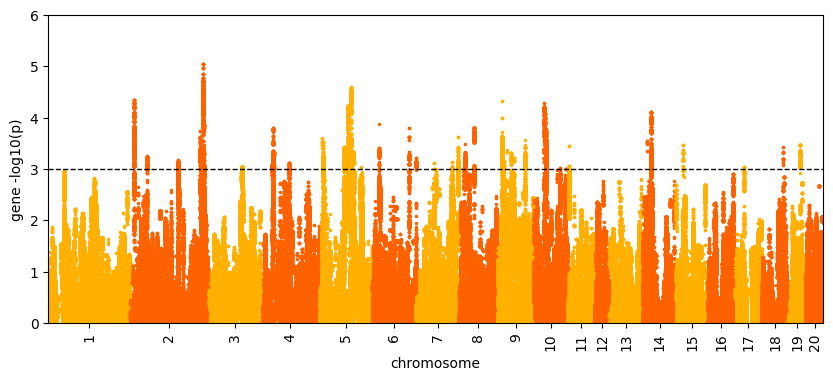

In [50]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=cig['PVAL'],pos=cig['0'],chr=cig['CHROM'],label='',
                    cut=0,lines=[cutoff],lines_colors=['black'], colors=[colour_dict['cigday'], colour_dict['cigday_alt']],
                    lines_widths = [1], lines_styles = ["--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('gene -log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')

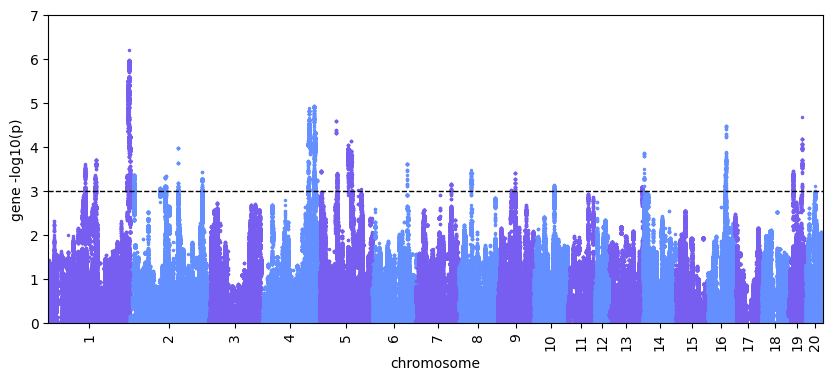

In [51]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=smk['PVAL'],pos=smk['0'],chr=smk['CHROM'],label='',
                    cut=0,lines=[cutoff],lines_colors=['black'], colors=[colour_dict['smkinit'], colour_dict['smkinit_alt']],
                    lines_widths = [1], lines_styles = ["--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('gene -log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')